In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
datapath = os.getcwd()
print(datapath)
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
#設定所有欄看的見
pd.set_option('display.max_columns', None)
#資料載入
datapath = r"C:\Users\user\Documents\Competition data\資料集"
df_train = pd.read_csv(os.path.join(datapath,'house_train.csv.gz'))
df_test = pd.read_csv(os.path.join(datapath,'house_test.csv.gz'))

C:\Users\user\Documents\Competition data\house_predict


In [3]:
#價格以log方式壓縮
ori_train_Y = np.log1p(df_train['SalePrice'])
#ID
ids = df_test['Id']
#訓練時將ID與輸出剃除
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1)
df_test = df_test.drop(['Id'] , axis=1)

#剔除oulier
#df_train = df_train[df_train.GrLivArea < 4500]
#df_train.reset_index(drop=True, inplace=True)

#先合併做前處理
df = pd.concat([df_train, df_test])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
def check_miss(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data.head(20))

In [5]:
check_miss(df_train)

              Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
LotConfig         0  0.000000


In [6]:
check_miss(df_test)

              Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageCond       78  0.053461
GarageFinish     78  0.053461
GarageYrBlt      78  0.053461
GarageQual       78  0.053461
GarageType       76  0.052090
BsmtCond         45  0.030843
BsmtExposure     44  0.030158
BsmtQual         44  0.030158
BsmtFinType1     42  0.028787
BsmtFinType2     42  0.028787
MasVnrType       16  0.010966
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtHalfBath      2  0.001371


In [7]:
df_train[df_train['GrLivArea']>4500]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial


In [8]:
df_test[df_test['GrLivArea']>4500]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1089,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,2007,New,Partial


In [9]:
Garge_cols=['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
Bstm_cols=['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

In [10]:
#Functional: Home functionality (Assume typical unless deductions are warranted)
df['Functional']=df['Functional'].fillna('Typ')
#missing時預設為標準型
df['Electrical']=df['Electrical'].fillna('SBrkr')

In [11]:
# 部分欄位缺值補 'None'
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'FireplaceQu', 'FireplaceQu', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass']
#類別損失值以None代替
for col in none_cols:
    df[col] = df[col].fillna("None")
# 數值部分欄位缺值填補 0
#因代表沒有
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
             'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
for col in zero_cols:
    df[col] = df[col].fillna(0)

In [12]:
# 數值部分欄位缺值補眾數
mode_cols = ['KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
df['MSZoning']=df.groupby('MSSubClass')['MSZoning'].transform(lambda x:x.fillna(x.mode()[0]))
# 'LotFrontage' 有空缺時, 以同一區 (Neighborhood) 的 LotFrontage 中位數填補 (可以視為填補一種群聚編碼 )
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
# Utilities 參考資訊很少, 所以直接捨棄
df = df.drop(['Utilities'], axis=1)

In [13]:
def seqEnocder(df,col):
    def trans(x,dict_):
        t = dict_.get(x)
        return t
    seq = df[col]
    sort_ =np.sort(seq.unique())
    dict_ = {value_:index_+1 for index_,value_ in enumerate(sort_) }
    df[col] = seq.map(lambda x:trans(x,dict_))
def seqEnocder_1(df,col):
    def trans(x,dict_):
        t = dict_.get(x)
        return t
    seq = df[col]
    sort_ =np.sort(seq.unique())
    dict_ ={'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0,'None':0}
    df[col] = seq.map(lambda x:trans(x,dict_))
def seqEnocder_2(df,col):
    def trans(x,dict_):
        t = dict_.get(x)
        return t
    seq = df[col]
    sort_ =np.sort(seq.unique())
    dict_ ={'GLQ':4,'ALQ':3,'BLQ':2,'Rec':1,'LwQ':0,'Unf':0,'NA':0,'None':0}
    df[col] = seq.map(lambda x:trans(x,dict_))

In [14]:
# 四個數值欄位, 因為相異值有限, 轉成文字
'''
label_cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for col in mode_cols:
    df[col] = df[col].astype(str)
'''

"\nlabel_cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']\nfor col in mode_cols:\n    df[col] = df[col].astype(str)\n"

In [15]:
check_miss(df)

               Total  Percent
SaleCondition      0      0.0
BsmtQual           0      0.0
Exterior1st        0      0.0
Exterior2nd        0      0.0
MasVnrType         0      0.0
MasVnrArea         0      0.0
ExterQual          0      0.0
ExterCond          0      0.0
Foundation         0      0.0
BsmtCond           0      0.0
RoofStyle          0      0.0
BsmtExposure       0      0.0
BsmtFinType1       0      0.0
BsmtFinSF1         0      0.0
BsmtFinType2       0      0.0
BsmtFinSF2         0      0.0
BsmtUnfSF          0      0.0
TotalBsmtSF        0      0.0
RoofMatl           0      0.0
YearRemodAdd       0      0.0


In [16]:
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal


In [17]:
'''
月特徵增加四季特徵
MSSubClass、YrSold、MoSold轉成文字型態
轉化ExterQual、ExterCond、HeatingQC、BsmtFinType1、BsmtFinType2為序列分數
將LotArea分級
增加品質特徵、房屋總面積、總廁所數、浴室分數
品質特徵:

'''

'\n月特徵增加四季特徵\nMSSubClass、YrSold、MoSold轉成文字型態\n轉化ExterQual、ExterCond、HeatingQC、BsmtFinType1、BsmtFinType2為序列分數\n將LotArea分級\n增加品質特徵、房屋總面積、總廁所數、浴室分數\n品質特徵:\n\n'

In [18]:
#特徵前處理
import copy
fea_df = copy.deepcopy(df)

In [19]:
def season(x):
    if x>=4 and x<7 :
        x='Spring'
    elif x>= 7 and x<10:
        x='Summer'
    elif x>= 10 and x<13:
        x='Fall'
    else:
        x="Winter"
    return x

In [20]:
#月份分四季
fea_df['Season'] = fea_df['MoSold'].map(lambda x:season(x))

In [21]:
# 四個數值欄位, 因為相異值有限, 轉成文字
label_cols = ['MSSubClass','MoSold','YearBuilt','GarageYrBlt']#房型跟月份
for col in label_cols:
    fea_df[col] = fea_df[col].astype(str)

In [22]:
#特徵衍生
#總房屋面積
fea_df['TotalSF'] = fea_df['TotalBsmtSF']+fea_df['1stFlrSF']+ fea_df['2ndFlrSF'] 
#總廁所數
fea_df['TotalBath'] = fea_df['BsmtFullBath']+fea_df['BsmtHalfBath']+fea_df['FullBath']+fea_df['HalfBath']
fea_df['TotalBath_score'] = 2*fea_df['BsmtFullBath']+1*fea_df['BsmtHalfBath']+3*fea_df['FullBath']+1*fea_df['HalfBath']
fea_df['Total_porch_sf'] = (fea_df['OpenPorchSF'] + fea_df['3SsnPorch'] +
                              fea_df['EnclosedPorch'] + fea_df['ScreenPorch'] +
                              fea_df['WoodDeckSF'])

In [23]:
trespilt = np.linspace(10000,50000,5)
#trespilt=list(range(10000,50000,10000))
def trelotarea(x,trespilt):
    if x <= trespilt[0]:
        x = 1
    elif x >trespilt[0] and x <= trespilt[1]:
        x=2
    elif x >trespilt[1] and x <= trespilt[2]:
        x=3
    elif x >trespilt[2] and x <= trespilt[3]:
        x=4
    else:
        x=5
    return x 

In [24]:
#將土地面積分級
fea_df['LotArea_grade']=fea_df['LotArea'].map(lambda x:(trelotarea(x,trespilt)))

In [25]:
#序列轉換
#seqEnocder(fea_df,'MSSubClass')
#品質轉換
Qual_cols=['ExterQual','ExterCond','HeatingQC','BsmtQual','BsmtCond','KitchenQual','FireplaceQu','GarageQual','GarageCond'
          ,'PoolQC']
for qcol in Qual_cols:
    seqEnocder_1(fea_df,qcol)

seqEnocder_2(fea_df,'BsmtFinType1')
seqEnocder_2(fea_df,'BsmtFinType2')

In [26]:
#裝修品質
#OverallQual整體裝修材料*OverallCond整體裝修
fea_df['Qual_Overall']=fea_df['OverallQual']*fea_df['OverallCond']
fea_df['Qual_Exter']=fea_df['ExterQual']*fea_df['ExterCond']
fea_df['Qual_Bsmt'] = fea_df['BsmtQual']*fea_df['BsmtCond']
fea_df['Qual_BsmtFinSF1'] = fea_df['BsmtFinType1']*fea_df['BsmtFinSF1']
fea_df['Qual_BsmtFinSF2'] = fea_df['BsmtFinType2']*fea_df['BsmtFinSF2']
fea_df['Qual_ALLBsmt'] = fea_df['Qual_Bsmt']*(fea_df['Qual_BsmtFinSF1']+fea_df['Qual_BsmtFinSF2'])
fea_df['Qual_SF']=fea_df['TotalBsmtSF']+2*fea_df['1stFlrSF']+ fea_df['2ndFlrSF'] -fea_df['LowQualFinSF']
fea_df['Qual_Kitchen'] = fea_df['KitchenAbvGr']*fea_df['KitchenQual']
fea_df['Qual_Fireplace']=fea_df['Fireplaces']*fea_df['FireplaceQu']
fea_df['Qual_Garage']=fea_df['GarageQual']*fea_df['GarageCond']
fea_df['Qual_Garagearea']=fea_df['GarageQual']*fea_df['GarageCond']*fea_df['GarageArea']
fea_df['Qual_pool']=fea_df['PoolArea']*fea_df['PoolQC']

In [27]:
#具有物
fea_df['haspool']=fea_df['PoolArea'].apply(lambda x: 1 if x>0 else 0)
fea_df['has2ndfloor'] = fea_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
fea_df['hasgarage'] = fea_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
fea_df['hasbsmt'] = fea_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
fea_df['hasfireplace'] = fea_df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
#二值化
fea_df['CentralAir']=fea_df['CentralAir'].apply(lambda x:1 if x=='Y' else 0)
fea_df['newhouse']=fea_df['SaleType'].apply(lambda x:1 if x=='New' else 0)
fea_df['Abnsale'] = fea_df['SaleCondition'].apply(lambda x:1 if x=='Abnorml'else 0)

In [28]:
fea_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Season,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,3,2,No,4,706.0,0,0.0,150.0,856.0,GasA,4,1,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,3,8,Typ,0,0,Attchd,2003.0,RFn,2.0,548.0,2,2,Y,0,61,0,0,0,0,0,None,None,0,2,2008,WD,Normal,Winter,2566.0,4.0,9.0,61,1,35,6,6,2824.0,0.0,16944.0,3422.0,3,0,4,2192.0,0,0,1,1,1,0,0,0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,3,2,Gd,3,978.0,0,0.0,284.0,1262.0,GasA,4,1,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,2,6,Typ,1,2,Attchd,1976.0,RFn,2.0,460.0,2,2,Y,298,0,0,0,0,0,0,None,None,0,5,2007,WD,Normal,Spring,2524.0,3.0,7.0,298,1,48,4,6,2934.0,0.0,17604.0,3786.0,2,2,4,1840.0,0,0,0,1,1,1,0,0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,3,2,Mn,4,486.0,0,0.0,434.0,920.0,GasA,4,1,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,3,6,Typ,1,2,Attchd,2001.0,RFn,2.0,608.0,2,2,Y,0,42,0,0,0,0,0,None,None,0,9,2008,WD,Normal,Summer,2706.0,4.0,9.0,42,2,35,6,6,1944.0,0.0,11664.0,3626.0,3,2,4,2432.0,0,0,1,1,1,1,0,0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,2,3,No,3,216.0,0,0.0,540.0,756.0,GasA,3,1,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,3,7,Typ,1,3,Detchd,1998.0,Unf,3.0,642.0,2,2,Y,0,35,272,0,0,0,0,None,None,0,2,2006,WD,Abnorml,Winter,2473.0,2.0,5.0,307,1,35,4,6,648.0,0.0,3888.0,3434.0,3,3,4,2568.0,0,0,1,1,1,1,0,1
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,3,2,Av,4,655.0,0,0.0,490.0,1145.0,GasA,4,1,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,3,9,Typ,1,2,Attchd,2000.0,RFn,3.0,836.0,2,2,Y,192,84,0,0,0,0,0,None,None,0,12,2008,WD,Normal,Fall,3343.0,4.0,9.0,276,2,40,6,6,2620.0,0.0,15720.0,4488.0,3,2,4,3344.0,0,0,1,1,1,1,0,0


In [29]:
#將資料分為數值、二元、類別型態
#數值型態需做偏態確認，有偏態時需做常態

In [30]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
objecttype= []
bionum=[]
for i in fea_df.columns:
    if fea_df[i].dtype in numeric_dtypes:
        if len(fea_df[i].unique())==2:
            bionum.append(i)
        else:
            numerics2.append(i)
    elif fea_df[i].dtype =='object':
        objecttype.append(i)

In [31]:
len(objecttype),len(bionum),len(numerics2)

(34, 8, 61)

In [32]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler() #z-scaler物件

In [33]:
#fea_df['MiscVal']=np.log1p(fea_df['MiscVal'])
#fea_df['PoolArea']=np.log1p(fea_df['PoolArea'])
#偏態測試
skew_features = fea_df[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
#正負偏態大於0.5視為偏態
high_skew = skew_features[abs(skew_features) > 0.5]
skew_index = high_skew.index
for i in skew_index:
    fea_df[i] = boxcox1p(fea_df[i], boxcox_normmax(fea_df[i] + 1))
    #fea_df[i] = np.log1p(fea_df[i])

In [34]:
#fea_df = fea_df.drop(['Qual_pool', 'PoolQC', 'PoolArea',], axis=1)

In [35]:
#one-hot EN
fea_df = pd.get_dummies(fea_df)
print(fea_df.shape)

(2919, 521)


In [36]:
fea_df.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,Yea

In [37]:
#利用歐式距離分群，須將數值壓制0,1之間
Kfea_df = copy.deepcopy(fea_df)
from sklearn.preprocessing import MinMaxScaler
MMscaler = MinMaxScaler()
Kfea_df[Kfea_df.columns] = MMscaler.fit_transform(Kfea_df[Kfea_df.columns])
Kfea_df.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,Yea

In [38]:
#有問題時把TEAR都改成類別資料

In [39]:
##Kmeans 分群
from sklearn.cluster import KMeans
for i in range(3,11,2):
    KM = KMeans(n_clusters=i)
    KM.fit(Kfea_df)
    name='KM'+str(i)
    fea_df[name]=KM.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [40]:
fea_df.head(10)

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,Yea

In [41]:
#group特徵
gro_df = copy.deepcopy(fea_df)
train_num = ori_train_Y.shape[0]
gro_df_train = gro_df[:train_num]
gro_df_test = gro_df[train_num:]

In [42]:
#合併saleprice
gro_df_train = pd.concat([gro_df_train,ori_train_Y],axis=1)
gro_df_train.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,YrSold,TotalSF,TotalBath,TotalBath_score,Total_porch_sf,LotArea_grade,Qual_Overall,Qual_Exter,Qual_Bsmt,Qual_BsmtFinSF1,Qual_BsmtFinSF2,Qual_ALLBsmt,Qual_SF,Qual_Kitchen,Qual_Fireplace,Qual_Garage,Qual_Garagearea,Qual_pool,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,newhouse,Abnsale,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1879,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1895,YearBuilt_1896,YearBuilt_1898,YearBuilt_1900,YearBuilt_1901,YearBuilt_1902,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1907,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,Yea

In [43]:
gro_col=['OverallQual','OverallCond']
#gro_col=['LotFrontage','OverallQual','OverallCond','TotalBath']
for gro in gro_col:
    a=gro_df_train['SalePrice'].groupby(gro_df_train[gro]).mean()
    a.name='mean_'+gro+'_SP'
    gro_df_train=pd.merge(gro_df_train,a,on=gro,how='left')
    gro_df_test=pd.merge(gro_df_test,a,on=gro,how='left')

In [44]:
##特徵處理完，分割數據集
train_num = ori_train_Y.shape[0]
ori_train_X = fea_df[:train_num]
ori_test_X = fea_df[train_num:]

In [45]:
gro_df_train= gro_df_train.drop('SalePrice',axis=1)

In [46]:
ori_train_X=gro_df_train
ori_test_X=gro_df_test

In [47]:
ori_train_X.shape

(1460, 527)

In [48]:
#刪掉預測後爛的index
badindex=[1298, 1324, 812, 916, 968, 970, 410, 462, 495, 523, 632, 688, 30]
ori_train_X=ori_train_X.drop(ori_train_X.index[badindex])
ori_train_Y=ori_train_Y.drop(ori_train_Y.index[badindex])
X_test=ori_test_X
X=ori_train_X
y=ori_train_Y

In [49]:
# Removes colums where the threshold of zero's is (> 99.95), means has only zero values 
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.95:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_test', X_test.shape)

X (1447, 512) y (1447,) X_test (1459, 512)


In [50]:
from sklearn.model_selection import KFold, cross_val_score
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [51]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline

# setup models hyperparameters using a pipline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together, while setting different parameters.
# This is a range of values that the model considers each time in runs a CV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet}
predictions = {}
scores = {}

for name, model in models.items():
    
    model.fit(X, y)
    predictions[name] = np.expm1(model.predict(X))
    
    score = cv_rmse(model, X=X)
    scores[name] = (score.mean(), score.std())

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
                         cv=KFold(n_splits=10, random_state=42, shuffle=True),
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values=False))],
         verbose=False)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lassocv',
                 LassoCV(alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                 0.0006, 0.0007, 0.0008],
                         copy_X=True,
                         cv=KFold(n_splits=10, random_state=42, shuffle=True),
                         eps=0.001, fit_intercept=True, max_iter=10000000.0,
                         n_alphas=100, n_jobs=None, normalize=False,
                         positive=False, precompute='auto', random_state=42,
                         selection='cyclic', tol=0.0001, verbose=False))],
         verbose=False)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('elasticnetcv',
                 ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                      0.0006, 0.0007],
                              copy_X=True,
                              cv=KFold(n_splits=10, random_state=42, shuffle=True),
                              eps=0.001, fit_intercept=True,
                              l1_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1],
                              max_iter=10000000.0, n_alphas=100, n_jobs=None,
                              normalize=False, positive=False,
                              precompute='auto', random_state=None,
                              selection='cyclic', tol=0.0001, verbose=0))],
         verbose=False)

In [52]:
#Fit the training data X, y
print('Elasticnet')
elastic_model = elasticnet.fit(X, y)
print('Lasso')
lasso_model = lasso.fit(X, y)
print('Ridge')
ridge_model = ridge.fit(X, y)

Elasticnet
Lasso
Ridge


In [53]:
# model blending function using fitted models to make predictions
def blend_models(X):
    return ((elastic_model.predict(X)) + (lasso_model.predict(X)) + (ridge_model.predict(X)))/3
blended_score = rmsle(y, blend_models(X))
print('RMSLE score on train data:')
print(rmsle(y, blend_models(X)))

RMSLE score on train data:
0.08415733589920965


Text(0.5, 0, 'Ridge Predictions (y_pred)')

Text(0, 0.5, 'Real Values (y_train)')

Text(0.5, 1.0, 'Ridge Predictions vs Real Values')

Text(0, 700000, 'Mean RMSE: 0.096508 / Std: 0.008726')

Text(0.5, 0, 'Lasso Predictions (y_pred)')

Text(0, 0.5, 'Real Values (y_train)')

Text(0.5, 1.0, 'Lasso Predictions vs Real Values')

Text(0, 700000, 'Mean RMSE: 0.096626 / Std: 0.008660')

Text(0.5, 0, 'ElasticNet Predictions (y_pred)')

Text(0, 0.5, 'Real Values (y_train)')

Text(0.5, 1.0, 'ElasticNet Predictions vs Real Values')

Text(0, 700000, 'Mean RMSE: 0.096499 / Std: 0.008600')

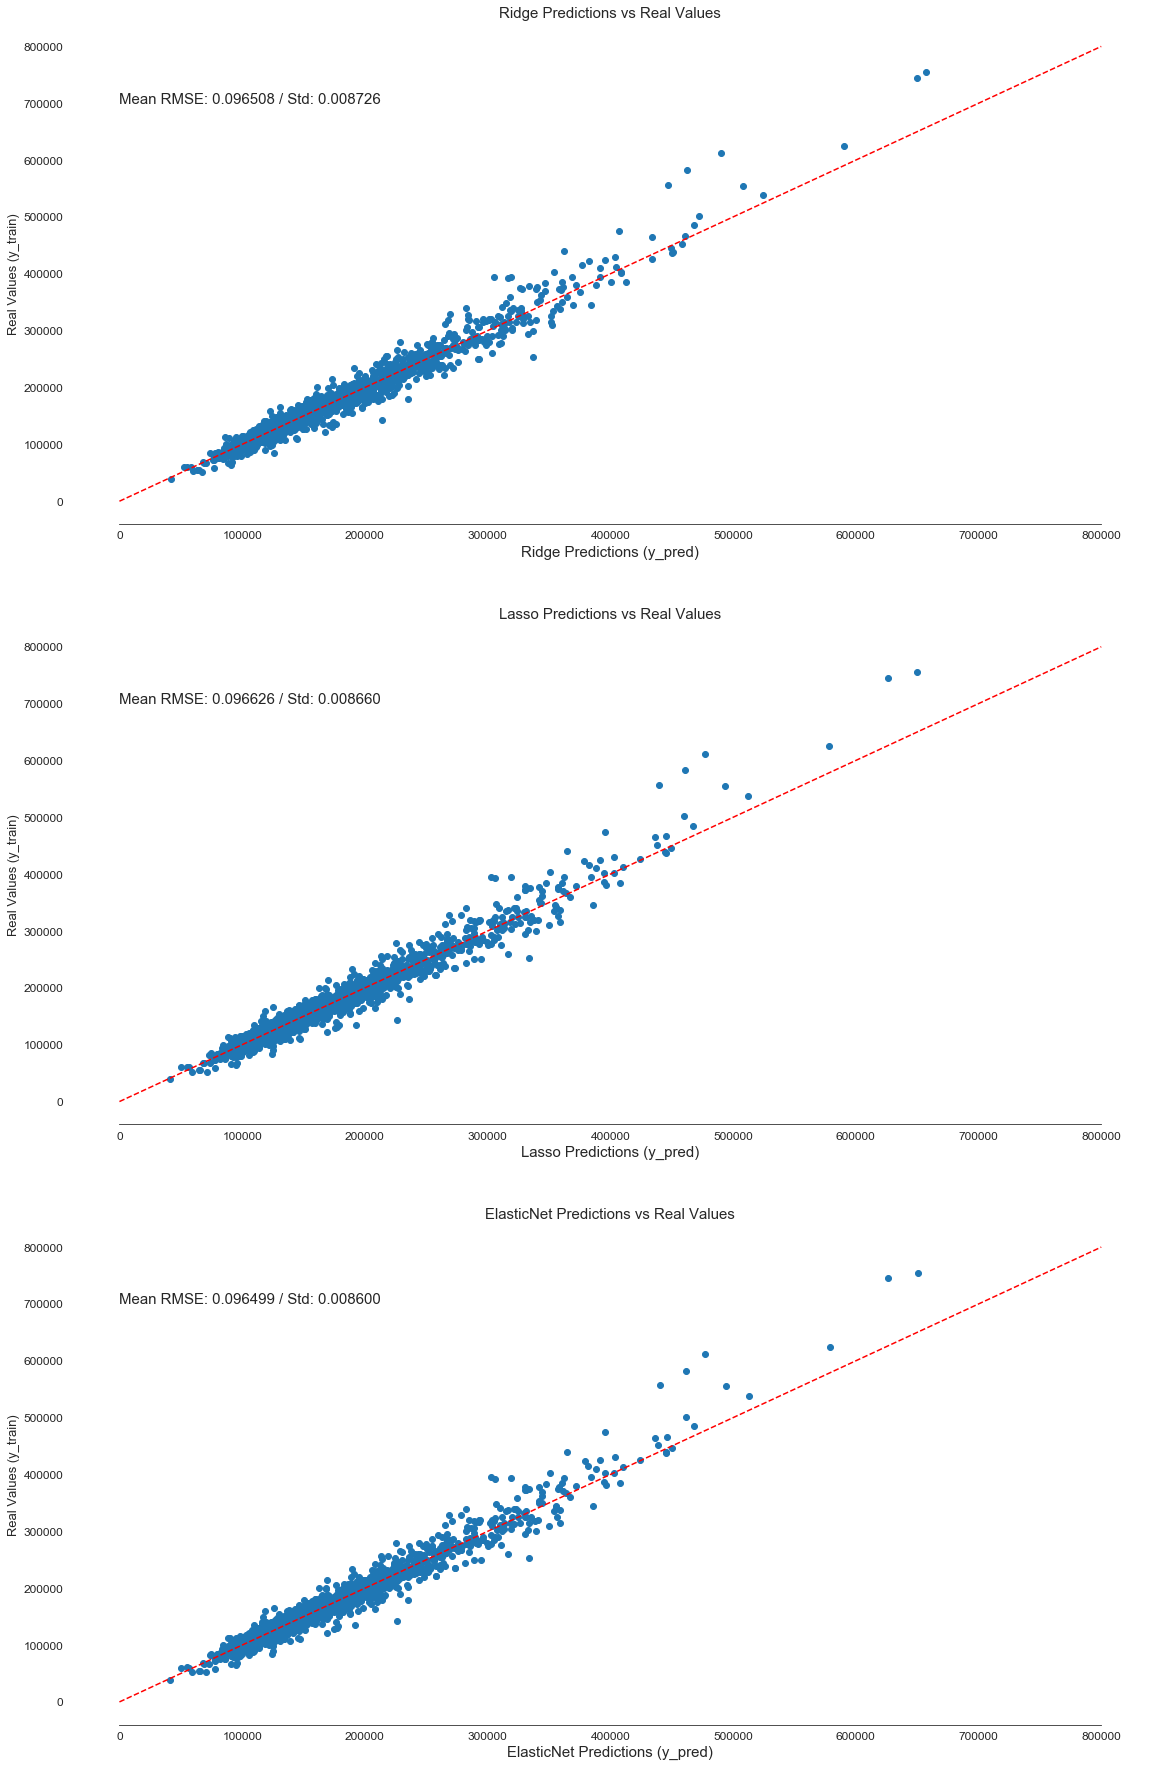

In [54]:
# visualise model performance
sns.set_style("white")
fig, axs = plt.subplots(ncols=0, nrows=3, figsize=(8, 7))
plt.subplots_adjust(top=3.5, right=2)

for i, model in enumerate(models, 1):
    plt.subplot(3, 1, i)
    plt.scatter(predictions[model], np.expm1(y))
    plt.plot([0, 800000], [0, 800000], '--r')

    plt.xlabel('{} Predictions (y_pred)'.format(model), size=15)
    plt.ylabel('Real Values (y_train)', size=13)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    plt.title('{} Predictions vs Real Values'.format(model), size=15)
    plt.text(0, 700000, 'Mean RMSE: {:.6f} / Std: {:.6f}'.format(scores[model][0], scores[model][1]), fontsize=15)
    #ax.xaxis.grid(False)
    sns.despine(trim=True, left=True)
plt.show()

Text(0, 0.09850778168079011, '0.096508')

Text(1, 0.09862648686282034, '0.096626')

Text(2, 0.09849926503001848, '0.096499')

Text(3, 0.08615733589920965, '0.084157')

Text(0, 0.5, 'Score (RMSE)')

Text(0.5, 0, 'Model')

Text(0.5, 1.0, 'Scores of Models')

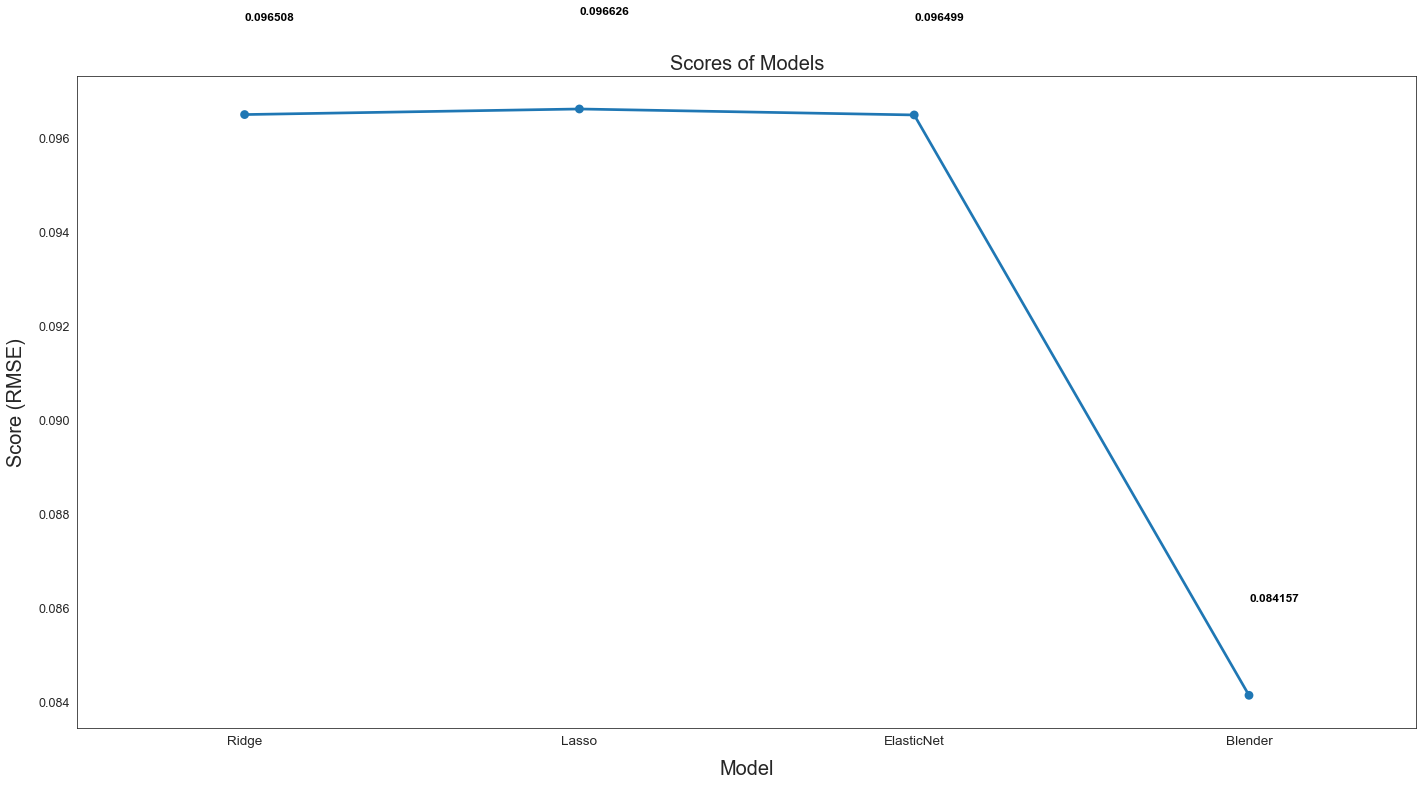

In [55]:
scores['Blender'] = (blended_score, 0)
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [56]:
sub = pd.DataFrame()
sub['Id'] = ids
sub['SalePrice'] = np.expm1(blend_models(X_test))
sub.to_csv('reg_submission_tt.csv',index=False)